# **Assignment \#3**: Machine Learning MC886/MO444
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2022s2



In [ ]:
# TODO: RA & Name 
print('RA: 181980' + 'Bruno Martinez de Farias')
print('RA: 220129' + 'Leonardo Mazzamboni Colussi')

## Objective 

Explore **neural networks** and develop the best possible model for the problem, avoiding overfitting. In particular, build an object recognition system to classify images using the [BloodMNIST dataset](https://doi.org/10.1016/j.dib.2020.105474) accurately. 

In this activity, **you are not allowed to use neural networks frameworks** (e.g., Pytorch, Tensorflow, Keras), except basic functions such as Dataloaders which are already specified in the code cells. You should implement the required methods using [NumPy](https://numpy.org/doc/1.23/user/index.html#user). Also, you can use ``scikit-learn`` (or similar libraries) to compute evaluation metrics, and all the plotting libraries are allowed too. 

We created a sanity check for all the methods you have to implement, so you can check whether the overall behavior of your algorithm is correct. However, it does not guarantee that your implementation is correct, unfortunately debugging neural networks models is a hard task.

## Dataset

BloodMNIST is one of the image datasets of [MedMNIST](https://medmnist.com/). It is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. It is split into a training set of 11,959 examples, a validation set of 1,712 examples, and a test set of 3,421 examples. Each example is a 3x28x28 RGB image, associated with a label from 8 classes.

Each example is assigned to one of the following labels:

|Class ID| Cell Type | #Images | % |
|--------|-----------|---------|---|
|   0    | basophils | 1218 | 7.13 |
|   1    | eosinophils | 3117 | 18.24 |
|   2    | erythroblasts | 1551 | 9.07 |
|   3    | immature granulocytes | 2895 | 16.94 |
|   4    | lymphocytes | 1214 | 7.10 |
|   5    | monocytes | 1420 | 8.31 |
|   6    | neutrophils | 3329 | 19.48 |
|   7    | platelets (thrombocytes) | 2348 |13.74 |


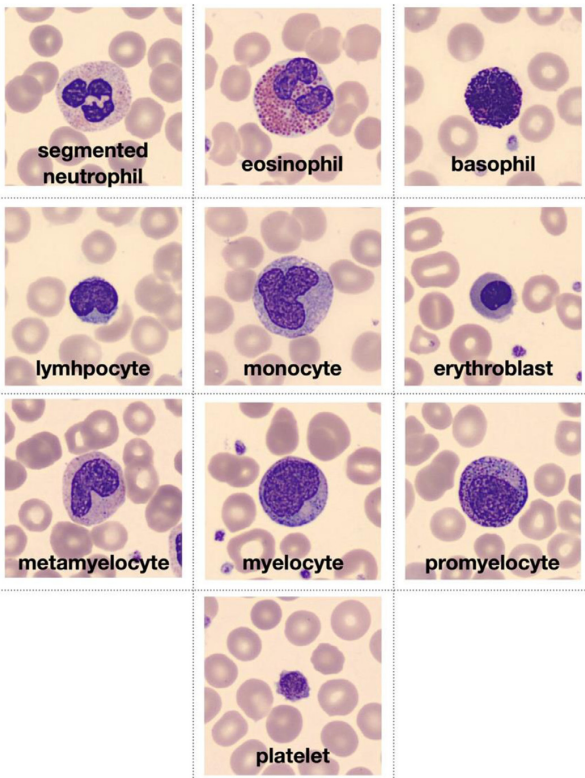

**Dataset Information:**

- You should respect the following training/validation/test split. Avoid overfitting.
- The data is available at Google Classroom or at https://drive.google.com/file/d/1DPGlDIRp_kGqhHyUAlkL7OH8RVbkRRbi/view?usp=sharing
- You should evaluate the models using **balanced accuracy** or **AUC**.

## Deadline
Friday, October 21 11:59pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- October 22 11:59pm : grade * 0.75
- October 23 11:59pm : grade * 0.5
- October 24 11:59pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-people group).**

In [1]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from typing import List
from abc import ABC, abstractmethod
from torch.utils.data import Dataset, DataLoader
import torch 

import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
# prepare data to use with Pytorch Dataloader

class BloodMNIST(Dataset):
    def __init__(self, x, y=None, transform=None):
        self._x = x
        self._y = y.squeeze() if y is not None else None
        self._transform = transform

    def __len__(self):
        return self._x.shape[0]

    def __getitem__(self, idx):                  
        image = self._x[idx]
        if self._transform is not None:        
            image = self._transform(image)
        
        image = image.flatten()
        if self._y is None:
            return image

        # one hot encoding
        label = [0] * 8
        label[self._y[idx]] = 1
        return image, torch.Tensor(label)

In [3]:
# an example of normalization function, but you can implement others
def normalize(X):
    return (X - X.mean())/(X.std() + 1e-8)

#### Loading data

In [4]:
# set the dataset path correctly 
dataset_path = 'bloodmnist.npz'
bloodmnist = np.load(dataset_path)

x_train, y_train = bloodmnist['train_images'], bloodmnist['train_labels']
x_val, y_val = bloodmnist['val_images'], bloodmnist['val_labels']

# you do not have access to the labels of the test set
x_test = bloodmnist['test_images']

In [5]:
train_set = BloodMNIST(x_train, y_train, transform=normalize)
val_set = BloodMNIST(x_val, y_val, transform=normalize)
test_set = BloodMNIST(x_test, transform=normalize)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

## Implementation tasks

#### Activation & Loss Functions

Activation functions are essential components of a neural network. So, explore different activation functions in your models and analyze the differences in the results. Also, implement the cross-entropy and use it as your loss function since you are working on a multi-class classification problem.

Implement, in the indicated place, the following functions:

* Softmax (its gradient is already implemented);
* Cross-Entropy (its gradient is already implemented);
* An activation function of your preference, as well as its gradient. It must be a subclass of ``BaseFunction``. (For reference, read this [blog post](https://dwaithe.github.io/blog_20170508.html).)

In [6]:
class BaseFunction(ABC):
    @abstractmethod
    def __call__(self, X):
        pass
        
    @abstractmethod
    def grad(self, X):
        pass


class ReLU(BaseFunction):    
    def __call__(self, X):
        return np.maximum(np.zeros_like(X), X)

    def grad(self, X):
        return np.where(X >= 0, 1, 0)

########################################################
# TODO: implement here another activation function

# Example:

class Activation(BaseFunction):    
    
    '''
    Sigmoid function
    '''
    
    def __call__(self, X):
        return 1 / (1 + np.exp(-X))

    def grad(self, X):
        fx = 1 / (1 + np.exp(-X))
        return fx * (1 - fx)

########################################################

class Softmax(BaseFunction):    
    
    def __call__(self, X):
        
        """
        Arguments:
        X: (np.array) input data

        Return:
        Softmax output
        """    
        ##################################
        # TODO: implement here the Softmax
        ##################################
        Z = X - np.amax(X, axis=1, keepdims=True)
        return np.exp(Z) / np.sum(np.exp(Z), axis=1).reshape(-1,1)

    def grad(self, X):
        return 1

class CrossEntropy(BaseFunction):  
    
    def __call__(self, Y, Y_pred):
        
        """
        Arguments:
        Y: (np.array) ground-truth labels
        Y_pred: (np.array) predicted labels

        Return:
        Cross-Entropy output
        """ 
        ##################################
        # TODO: implement here the Cross-Entropy
        ##################################
        n = float(Y_pred.shape[0])
        return -1 / n * np.sum(Y * np.log(Y_pred + 1e-8))

    def grad(self, Y, Y_pred):
        return Y_pred - Y # gradient with respect to Softmax's input

**Sanity Check**

In [7]:
######## checking Softmax ########

s = Softmax()
x = np.array([[0,0],
              [1,2],
              [-3,2]])

expected_softmax = np.array([[0.5       , 0.5       ],
                             [0.26894142, 0.73105858],
                             [0.00669285, 0.99330715]])

result_softmax = s(x)

assert (abs(result_softmax - expected_softmax) < 1e-8).all(), f"Expected result for softmax is {expected_softmax}, but it returns {result_softmax}"

In [8]:
######## checking CrossEntropy ########

Y = np.array([[0, 1, 1],
              [1, 0, 0]])

Y_pred = np.array([[0, 1, 1],
                   [0.7, 0, 0.3],])

expected_ce = 0.1783374548265092
cross_entropy = CrossEntropy()
ce_result = cross_entropy(Y, Y_pred) 

assert abs(ce_result - expected_ce) < 1e-8, f"Expected result for cross entropy is {expected_ce}, but it returns {ce_result}"

expected_grad = np.array([[ 0. ,  0. ,  0. ],
                          [-0.3,  0. ,  0.3]])

grad = cross_entropy.grad(Y, Y_pred)

assert (abs(grad - expected_grad) < 1e-8).all(), f"Expected result for cross entropy gradient is {expected_grad}, but it returns {grad}"

#### Model

In a neural network, the predictions are made using an algorithm called Feedforward, also known as the forward step. Thus, you have to implement this method to make predictions using your models. 

In addition, it is critical to initialize the network weights properly to ensure a better-performing model. Otherwise, it can give rise to a Vanishing Gradient or Exploding Gradient problem. So, try different weights initialization techniques and see what happens. We already implemented the random and [He et al.](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) Normal initialization for you :D

Implement, in the indicated place, the following methods:

* Feedforward, also known as the forward step;
* A weight initialization method of your choice. (For reference, read this [blog post](https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/).)

PS. Note that the weight matrices $W$ in the network are constructed so that $w^{l}_{i,j}$ is the weight that connects the i-th neuron in the l-th layer to the j-th neuron in the following layer, as illustrated below.



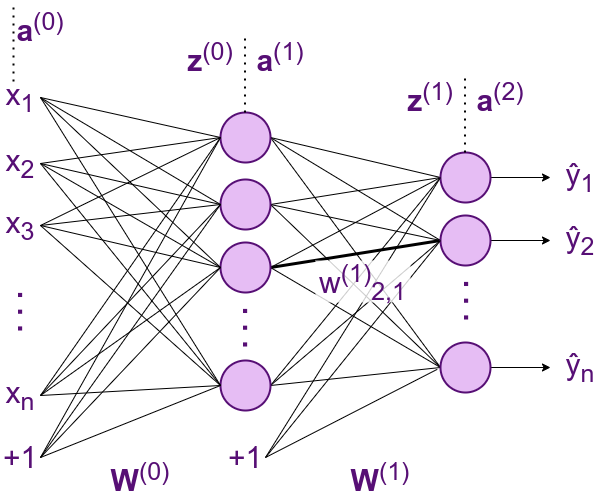


**Feed Forward**:

$a^{(l)} = f_{(l-1)}(z^{(l-1)})$

In [19]:
class Model:
    
    def __init__(self, 
                 layers_dims: List[int], 
                 activation_funcs: List[BaseFunction],
                 initialization_method: str = "random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        activation_funcs: (list) a list with the activation functions 
        initialization_method: (str) indicates how to initialize the parameters

        Example:
        
        # a model architecture with layers 2 x 1 x 2 and 2 ReLU as activation functions
        >>> m = Model([2, 1, 2], [ReLU(), ReLU()])
        """

        assert all([isinstance(d, int) for d in layers_dims]), \
        "It is expected a list of int to the param ``layers_dims"

        assert all([isinstance(a, BaseFunction) for a in activation_funcs]), \
        "It is expected a list of BaseFunction to the param ``activation_funcs´´"
        
        self.layers_dims = layers_dims
        self.activation_funcs = activation_funcs
        self.weights, self.bias = self.initialize_model(initialization_method)


    def __len__(self):
        return len(self.weights)


    def initialize_model(self, method="random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        method: (str) indicates how to initialize the parameters

        Return: a list of matrices (np.array) of weights and a list of 
        matrices (np.array) of biases.
        """
        
        weights = []
        bias = []
        n_layers = len(self.layers_dims)
        
        for l in range(0, n_layers-1):
            # the weight w_i,j  connects the i-th neuron in the current layer to
            # the j-th neuron in the next layer          
            W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1]) + (1e-8)
            b = np.random.randn(1, self.layers_dims[l + 1]) + (1e-8)
            
            # He et al. Normal initialization
            if method.lower() == 'he':
                W = W * np.sqrt(2/self.layers_dims[l]) + (1e-8)
                b = b * np.sqrt(2/self.layers_dims[l]) + (1e-8)

            ###################################################
            # TODO: implement another initialization method
            
            # Uniform distribution: https://medium.com/geekculture/weight-initialization-in-neural-nets-78091cfee93
            if method.lower() == 'Unif':
                W = W * np.sqrt(1/self.layers_dims[l]) + (1e-8)
                b = b * np.sqrt(1/self.layers_dims[l]) + (1e-8)
            ###################################################

            weights.append(W)
            bias.append(b)

        return weights, bias

    
    def forward(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Predictions for the input data (np.array)
        """      
        activation = X
        self.activations = [X]
        self.Z_list = []
                
        #############################################################################
        # TODO: implement here the forward step.
        #
        # A few more instructions:
        # Note that the weights, bias and activation functions are class variables,
        # then you can access them via ``self``.
        #
        # You should store the input Z of each activation function in ``Z_list``,
        # and the output of the activation functions in ``activations``. These
        # information will be important when you implement the backward pass.
        #############################################################################
        
        for l in range(len(self.layers_dims) - 1):
            Z = np.dot(self.activations[l], self.weights[l]) + self.bias[l]
            
            self.Z_list.append(Z)
            self.activations.append(self.activation_funcs[l](Z))
            
        return self.activations[-1]

**Sanity check**

In [10]:
######## checking Forward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), ReLU()])

X = np.array([[0, 1],
              [-1,0]])

W1 = np.array([[2],
               [1]])
b1 = np.array([[1]])

W2 = np.array([[2, 3]])
b2 = np.array([[1, -1]])

m.weights = [W1, W2]
m.bias = [b1, b2]

expected_prediction = np.array([[5,5],
                                [1,0]])

expected_Z_list = [np.array([[2],
                             [-1]]),                
                   np.array([[5,5],
                             [1,-1]]),]

expected_activations = [X,                        
                        np.array([[2],
                                  [0]]),                                            
                        expected_prediction]

#forward pass
prediction = m.forward(X)

for l, (expected_z, z) in enumerate(zip(expected_Z_list, m.Z_list)):
    assert ((z - expected_z) < 1e-8).all(), \
    f"Forward pass {l}: expected Z list is {expected_z}, but it returns {z}"

for l, (expected_a, a) in enumerate(zip(expected_activations, m.activations)):
    assert (abs(a - expected_a) < 1e-8).all(), \
    f"Forward pass {l}: expected activations are {expected_a}, but it returns {a}"

assert (abs(prediction - expected_prediction) < 1e-8).all(), \
f"Forward: expected result is {expected_prediction}, but it returns {prediction}"

#### Optimizers

Once you have designed your neural network's topology/architecture, it is time to train it. To do so, you need to select an optimizer (e.g., SGD, Momentum, Adagrad, Adam, RMSProp) that will update the network's weights. 

Implement in the indicated place:

* Stochastic Gradient Descent (SGD);
* Another optimizer of your preference. It must be a subclass of ``BaseOptimizer``. (For reference, read http://ruder.io/optimizing-gradient-descent.)

In [16]:
class BaseOptimizer(ABC):  
    
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def step(self, grads):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.
        
        Return: 
        """
        pass

class SGDOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3):
        self.model = model
        self.lr = lr

    def step(self, grads: List):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.
        
        Return: 
        """
        
        for l in range(len(self.model.layers_dims) - 1):
            self.model.weights[l] = self.model.weights[l] - self.lr * grads[l][0]
            self.model.bias[l] = self.model.bias[l] - self.lr * grads[l][1]
         
            
###################################
# TODO: implement another optimizer
###################################      


class MomentumOptim(BaseOptimizer):
    def __init__(self, model, lr=1e-3, gamma=0.9):
        self.model = model
        self.lr = lr
        self.gamma = gamma
        
        self.momentum_w = [np.zeros_like(self.model.weights[w]) for w in range(len(self.model.weights))]
        self.momentum_b = [np.zeros_like(self.model.bias[b]) for b in range(len(self.model.bias))]

    def step(self, grads: List):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.
        
        Return: 
        """       
        # https://ruder.io/optimizing-gradient-descent/index.html#momentum (reference website above this cell)

        for l in range(len(grads)):
            self.momentum_w[l] = self.gamma * self.momentum_w[l] + self.lr * grads[l][0]
            self.momentum_b[l] = self.gamma * self.momentum_b[l] + self.lr * grads[l][1]     

            self.model.weights[l] = self.model.weights[l] - self.momentum_w[l]
            self.model.bias[l] =  self.model.bias[l] - self.momentum_b[l]

**Sanity check**

The sanity check of SGD is placed after ``Trainer`` because it uses the backpropagation algorithm to compute the gradients.

#### Trainer

A weight $w_{i,j}$ of a neural network is updated based on the gradient of the loss function for $w_{i,j}$. Then, we need to compute the gradient of the loss function with respect to all the weights and biases in each layer in the network. This process is called backpropagation, a.k.a backward step. 

Implement:
* Backpropagation algorithm.

> *Hint: use the following recursive equations to compute the backpropagation.*
>
> $\frac{\partial C}{\partial z^{(L-1)}} = \frac{\partial C}{\partial a^{(L)}} \cdot \frac{\partial C}{\partial z^{(L-1)}}$
>
> $\frac{\partial C}{\partial z^{(l)}} = [\frac{\partial C}{\partial z^{(l+1)}} \cdot W_{(l+1)}^T] \odot \frac{\partial f_{(l)}}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial W^{(l)}} = \frac{1}{m} \cdot a^{(l)^T} \cdot \frac{\partial C}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial b^{(l)}} = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial C}{\partial z_i^{(l)}}$
>
> Where $C$ is your cost/loss function, $m$ is the batch size,  $a^{(L)}$ is the last activation function output, $z_i^{(l)}$ is the i-th row of the matrix $z^{(l)}$, and $\odot$ is the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))/element-wise product. 

In [12]:
class Trainer:
    
    def __init__(self, model, optimizer, loss_func):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.batch_size = 0
        
    def backward(self, Y):
        """
        Arguments:
        Y: (np.array) ground truth/label vector.

        Return: 
        A list of tuples of matrices (weights' gradient, biases' gradient) both in np.array format.
        The order of this list should be the same as the model's weights. 
        For example: [(dW0, db0), (dW1, db1), ... ].
        """
        
        ############################################################
        # TODO: implement here the backward step.
        ############################################################        
        
        grad_w = []
        grad_b = []
        hidden_l = len(self.model.layers_dims) - 2
        
        dz = self.loss_func.grad(Y, self.model.activations[-1]) * self.model.activation_funcs[-1].grad(self.model.Z_list[-1])
        
        for l in range(hidden_l, -1, -1):
            
            dW = 1/float(self.batch_size) * (self.model.activations[l].T @ dz) 
            db = 1/float(self.batch_size) * np.sum(dz, axis=0, keepdims=True)
            
            if l > 0:
                dz = (dz @ self.model.weights[l].T) * self.model.activation_funcs[l-1].grad(self.model.Z_list[l-1]) 
            
            grad_w.append(dW), grad_b.append(db)
            
        grad_w.reverse()
        grad_b.reverse()
        
        return list(zip(grad_w, grad_b))
    
    
    def train(self, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader):
        
        """
        Arguments:
        n_epochs: (int) number of epochs
        train_loader: (DataLoader) train DataLoader
        val_loader: (DataLoader) validation DataLoader

        Return: 
        A dictionary with the log of train and validation loss along the epochs
        """
        log_dict = {'epoch': [], 
                   'train_loss': [], 
                   'val_loss': []}

        self.batch_size = train_loader.batch_size
        for epoch in tqdm.tqdm_notebook(range(n_epochs)):
            train_loss_history = []
            
            for i, batch in enumerate(train_loader):                
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()                         
                Y_pred = self.model.forward(X)
                train_loss = self.loss_func(Y, Y_pred)
                train_loss_history.append(train_loss)

                grads = self.backward(Y)
                self.optimizer.step(grads)

            val_loss_history = []
            for i, batch in enumerate(val_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)
                val_loss = self.loss_func(Y, Y_pred)
                val_loss_history.append(val_loss)

            # appending losses to history
            train_loss = np.array(train_loss_history).mean()
            val_loss = np.array(val_loss_history).mean()
            
            log_dict['epoch'].append(epoch)
            log_dict['train_loss'].append(train_loss)
            log_dict['val_loss'].append(val_loss)
        
        return log_dict

**Sanity check**

In [13]:
######## checking Backward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0, 1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1], 
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)

# We let this value just in case you need to check your results
#
# expected_dZ1 = np.array([[ 0.5       , -0.5       ],
#                         [-0.11920292,  0.11920292]])
#
# expected_dZ0 = np.array([[-0.5],
#                          [ 0. ]])
#
# y_pred = np.array([[0.5       , 0.5       ],
#                    [0.88079708, 0.11920292]])


expected_dW1 = np.array([[ 0.5, -0.5]])

expected_db1 = np.array([[ 0.19039854, -0.19039854]])

expected_dW0 = np.array([[ 0.  ],
                         [-0.25]])

expected_db0 = np.array([[-0.25]])

dW1, db1 = grads[1]
assert (abs(expected_dW1 - dW1) < 1e-8).all(), f"Expected result for dW1 is {expected_dW1}, but it returns {dW1}"
assert (abs(expected_db1 - db1) < 1e-8).all(), f"Expected result for db1 is {expected_db1}, but it returns {db1}"

dW0, db0 = grads[0]
assert (abs(expected_dW0 - dW0) < 1e-8).all(), f"Expected result for dW0 is {expected_dW0}, but it returns {dW0}"
assert (abs(expected_db0 - db0) < 1e-8).all(), f"Expected result for db0 is {expected_db0}, but it returns {db0}"

#### Usage example

Usage example of the framework we just created.

In [14]:
# Auxiliar function to plot loss along the epochs
def plot_history(history):
    """
    Plot loss history
    """
    fig, ax = plt.subplots()
    ax.plot(history['train_loss'], color='#407cdb', label='Train')
    ax.plot(history['val_loss'],color='#db5740', label='Validation')
    
    ax.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()  
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss along the training')
    plt.show()

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/15 [00:00<?, ?it/s]

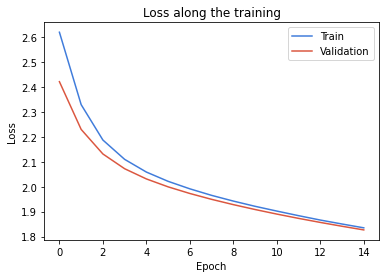

In [15]:
model = Model([2352, 500, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)

## Exploratory activities

For all exercises, plot the loss along the epochs and print your model's performance in the validation set.


1. (1 point) Design a Neural Network, using one or two hidden layers, ReLU and softmax as activation functions, random weight initialization, and SGD to train it. You should choose an appropriate learning rate and a number of epochs.

**Solução**

Primeiramente, definiu-se uma função de leitura e concatenação, por meio dos *batches*, das *targets* preditas pela rede e das *targets* reais para um futuro cálculo das métricas de validação do modelo. Posteriormente, realizou-se uma análise gráfica da *loss-function*, variando o *learning rate (lr)* tal que $lr \in \{10^{-3}, 10^{-4}, 10^{-5}\}$, com base nos ganhos conforme o aumento do número de épocas consideradas ($epochs \in [1,100]$). Os pesos foram iniciados aleatoriamente com base em uma distribuição Normal padrão.

In [21]:
def target_eval(model, trainer, loader):

        output_dict = {'y_true': [],
                       'y_true_label': [],
                       'y_pred': [],
                       'y_pred_auc': []}

        for epoch, batch in enumerate(loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_label = np.argmax(Y, axis=1)
                
                Y_pred = trainer.model.forward(X)
                Y_pred_auc = Y_pred[:, 1]

                Y_pred = np.argmax(Y_pred, axis=1)

                output_dict['y_true_label'].extend(Y_label) 
                output_dict['y_pred'].extend(Y_pred)

                output_dict['y_true'].extend(Y) 
                output_dict['y_pred_auc'].extend(Y_pred_auc.reshape(-1, 1))
                
        return output_dict

In [30]:
def best_epoch(history, epsilon):
    for i in range(len(history['epoch'])):
        if abs(history['val_loss'][i] -  history['val_loss'][i+1]) <=  epsilon:
            return history['epoch'][i]
    

### $lr = 10^{-5}$

In [18]:
baseline_rnd = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="random")
bs_opt_rnd = SGDOptimizer(baseline_rnd, lr=1e-5)
bs_trainer_rnd = Trainer(baseline_rnd, bs_opt_rnd, CrossEntropy())

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

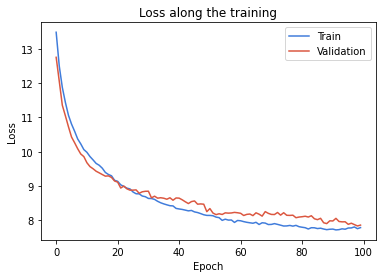

In [20]:
h_baseline_rnd = bs_trainer_rnd.train(100, train_loader, val_loader)
plot_history(h_baseline_rnd)

In [27]:
output_bs_rnd_train = target_eval(baseline_rnd, bs_trainer_rnd, train_loader)
output_bs_rnd_val = target_eval(baseline_rnd, bs_trainer_rnd, val_loader)

bs_bal_acc_rnd_train = balanced_accuracy_score(output_bs_rnd_train['y_true_label'], output_bs_rnd_train['y_pred'])
bs_auc_rnd_train = roc_auc_score(output_bs_rnd_train['y_true'], output_bs_rnd_train['y_pred_auc'])

bs_bal_acc_rnd_val = balanced_accuracy_score(output_bs_rnd_val['y_true_label'], output_bs_rnd_val['y_pred'])
bs_auc_rnd_val = roc_auc_score(output_bs_rnd_val['y_true'], output_bs_rnd_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bs_bal_acc_rnd_train,4), '\nauc:', round(bs_auc_rnd_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bs_bal_acc_rnd_val,4), '\nauc:', round(bs_auc_rnd_val,4))

Treino 
acurácia balanceada: 0.5414 
auc: 0.5714


Validação 
acurácia balanceada: 0.5385 
auc: 0.5469


### $lr = 10^{-4}$

In [22]:
baseline2_rnd = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="random")
bs_opt2_rnd = SGDOptimizer(baseline2_rnd, lr=1e-4)
bs_trainer2_rnd = Trainer(baseline2_rnd, bs_opt2_rnd, CrossEntropy())

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

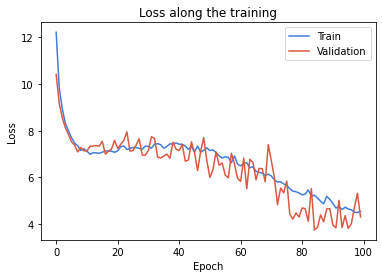

In [23]:
h_baseline2_rnd = bs_trainer2_rnd.train(100, train_loader, val_loader)
plot_history(h_baseline2_rnd)

In [28]:
output_bs2_rnd_train = target_eval(baseline2_rnd, bs_trainer2_rnd, train_loader)
output_bs2_rnd_val = target_eval(baseline2_rnd, bs_trainer2_rnd, val_loader)

bs_bal_acc2_rnd_train = balanced_accuracy_score(output_bs2_rnd_train['y_true_label'], output_bs2_rnd_train['y_pred'])
bs_auc2_rnd_train = roc_auc_score(output_bs2_rnd_train['y_true'], output_bs2_rnd_train['y_pred_auc'])

bs_bal_acc2_rnd_val = balanced_accuracy_score(output_bs2_rnd_val['y_true_label'], output_bs2_rnd_val['y_pred'])
bs_auc2_rnd_val = roc_auc_score(output_bs2_rnd_val['y_true'], output_bs2_rnd_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bs_bal_acc2_rnd_train,4), '\nauc:', round(bs_auc2_rnd_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bs_bal_acc2_rnd_val,4), '\nauc:', round(bs_auc2_rnd_val,4))

Treino 
acurácia balanceada: 0.5315 
auc: 0.5349


Validação 
acurácia balanceada: 0.5099 
auc: 0.55


### $lr = 10^{-3}$

In [29]:
baseline3_rnd = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="random")
bs_opt3_rnd = SGDOptimizer(baseline3_rnd, lr=1e-3)
bs_trainer3_rnd = Trainer(baseline3_rnd, bs_opt3_rnd, CrossEntropy())

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

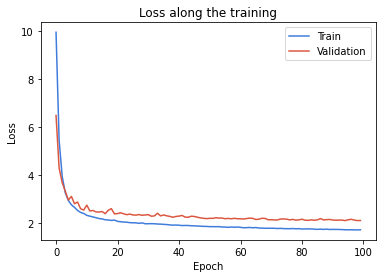

In [30]:
h_baseline3_rnd = bs_trainer3_rnd.train(100, train_loader, val_loader)
plot_history(h_baseline3_rnd)

In [35]:
output_bs3_rnd_train = target_eval(baseline3_rnd, bs_trainer3_rnd, train_loader)
output_bs3_rnd_val = target_eval(baseline3_rnd, bs_trainer3_rnd, val_loader)

bs_bal_acc3_rnd_train = balanced_accuracy_score(output_bs3_rnd_train['y_true_label'], output_bs3_rnd_train['y_pred'])
bs_auc3_rnd_train = roc_auc_score(output_bs3_rnd_train['y_true'], output_bs3_rnd_train['y_pred_auc'])

bs_bal_acc3_rnd_val = balanced_accuracy_score(output_bs3_rnd_val['y_true_label'], output_bs3_rnd_val['y_pred'])
bs_auc3_rnd_val = roc_auc_score(output_bs3_rnd_val['y_true'], output_bs3_rnd_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bs_bal_acc3_rnd_train,4), '\nauc:', round(bs_auc3_rnd_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bs_bal_acc3_rnd_val,4), '\nauc:', round(bs_auc3_rnd_val,4))

Treino 
acurácia balanceada: 0.2744 
auc: 0.5609


Validação 
acurácia balanceada: 0.2466 
auc: 0.5735


> What are the conclusions? (1-2 paragraphs)


**Resposta:** Notou-se, sobretudo, que a inicialização randômica dos pesos e do *bias* não é uma boa alternativa devido a sua característica de *overflow* e instabilidade. Ainda, observou-se que para esse método de inicialização, o *learning rate* que apresentou melhor performance, de forma geral, foi de $lr = 1e{-5}$ em termos de acurácia (aproximadamente, $54\%$ no treino e na validação) e AUC (aproximadamente, $57\%$ no treino e $55\%$ na validação).

Para $lr = 1e{-4}$, obteve-se valores dessas métricas aproximadas ao caso anterior, no entanto, a curva de *loss* na validação apresentou a maior instabilidade dentre as três abordagens. Por sua vez, para $lr = 1e{-3}$ encontrou-se mais estabilidade e poucas épocas seriam necessárias para obter este cenário estável da *loss*, porém a acurácia balanceada foi muito inferior aos demais casos.

2. (2 points) Experiment other two weight & bias initialization techniques (He et al. Normalization, and the other one you implemented).

**Solução**


# He et al. Normal initialization

### $lr = 10^{-5}$

In [32]:
baseline_he = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
bs_opt_he = SGDOptimizer(baseline_he, lr=1e-5)
bs_trainer_he = Trainer(baseline_he, bs_opt_he, CrossEntropy())

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

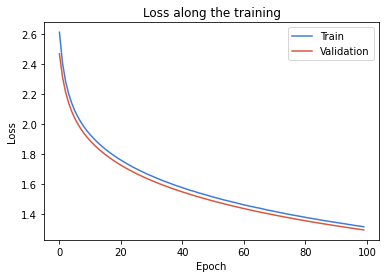

In [33]:
h_baseline_he = bs_trainer_he.train(100, train_loader, val_loader)
plot_history(h_baseline_he)

In [34]:
output_bs_he_train = target_eval(baseline_he, bs_trainer_he, train_loader)
output_bs_he_val = target_eval(baseline_he, bs_trainer_he, val_loader)

bs_bal_acc_he_train = balanced_accuracy_score(output_bs_he_train['y_true_label'], output_bs_he_train['y_pred'])
bs_auc_he_train = roc_auc_score(output_bs_he_train['y_true'], output_bs_he_train['y_pred_auc'])

bs_bal_acc_he_val = balanced_accuracy_score(output_bs_he_val['y_true_label'], output_bs_he_val['y_pred'])
bs_auc_he_val = roc_auc_score(output_bs_he_val['y_true'], output_bs_he_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bs_bal_acc_he_train,4), '\nauc:', round(bs_auc_he_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bs_bal_acc_he_val,4), '\nauc:', round(bs_auc_he_val,4))

Treino 
acurácia balanceada: 0.4638 
auc: 0.5596


Validação 
acurácia balanceada: 0.4723 
auc: 0.5602


### $lr = 10^{-4}$

In [36]:
baseline2_he = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
bs_opt2_he = SGDOptimizer(baseline2_he, lr=1e-4)
bs_trainer2_he = Trainer(baseline2_he, bs_opt2_he, CrossEntropy())

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

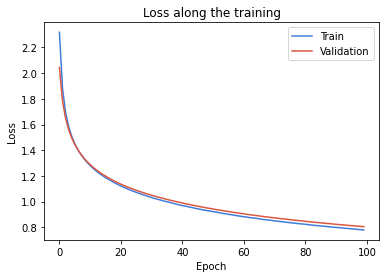

In [37]:
h_baseline2_he = bs_trainer2_he.train(100, train_loader, val_loader)
plot_history(h_baseline2_he)

In [38]:
output_bs2_he_train = target_eval(baseline2_he, bs_trainer2_he, train_loader)
output_bs2_he_val = target_eval(baseline2_he, bs_trainer2_he, val_loader)

bs_bal_acc2_he_train = balanced_accuracy_score(output_bs2_he_train['y_true_label'], output_bs2_he_train['y_pred'])
bs_auc2_he_train = roc_auc_score(output_bs2_he_train['y_true'], output_bs2_he_train['y_pred_auc'])

bs_bal_acc2_he_val = balanced_accuracy_score(output_bs2_he_val['y_true_label'], output_bs2_he_val['y_pred'])
bs_auc2_he_val = roc_auc_score(output_bs2_he_val['y_true'], output_bs2_he_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bs_bal_acc2_he_train,4), '\nauc:', round(bs_auc2_he_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bs_bal_acc2_he_val,4), '\nauc:', round(bs_auc2_he_val,4))

Treino 
acurácia balanceada: 0.6917 
auc: 0.557


Validação 
acurácia balanceada: 0.6837 
auc: 0.5573


### $lr = 10^{-3}$

In [39]:
baseline3_he = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
bs_opt3_he = SGDOptimizer(baseline3_he, lr=1e-3)
bs_trainer3_he = Trainer(baseline3_he, bs_opt3_he, CrossEntropy())

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

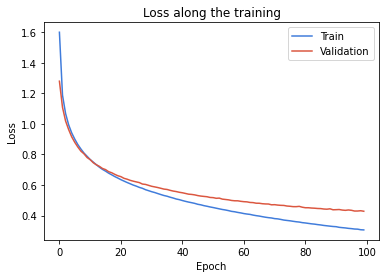

In [40]:
h_baseline3_he = bs_trainer3_he.train(100, train_loader, val_loader)
plot_history(h_baseline3_he)

In [41]:
output_bs3_he_train = target_eval(baseline3_he, bs_trainer3_he, train_loader)
output_bs3_he_val = target_eval(baseline3_he, bs_trainer3_he, val_loader)

bs_bal_acc3_he_train = balanced_accuracy_score(output_bs3_he_train['y_true_label'], output_bs3_he_train['y_pred'])
bs_auc3_he_train = roc_auc_score(output_bs3_he_train['y_true'], output_bs3_he_train['y_pred_auc'])

bs_bal_acc3_he_val = balanced_accuracy_score(output_bs3_he_val['y_true_label'], output_bs3_he_val['y_pred'])
bs_auc3_he_val = roc_auc_score(output_bs3_he_val['y_true'], output_bs3_he_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bs_bal_acc3_he_train,4), '\nauc:', round(bs_auc3_he_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bs_bal_acc3_he_val,4), '\nauc:', round(bs_auc3_he_val,4))

Treino 
acurácia balanceada: 0.8958 
auc: 0.6421


Validação 
acurácia balanceada: 0.8178 
auc: 0.6382


# Uniform distribution initialization

### $lr = 10^{-5}$

In [42]:
baseline_Unif = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="Unif")
bs_opt_Unif = SGDOptimizer(baseline_Unif, lr=1e-5)
bs_trainer_Unif = Trainer(baseline_Unif, bs_opt_Unif, CrossEntropy())

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

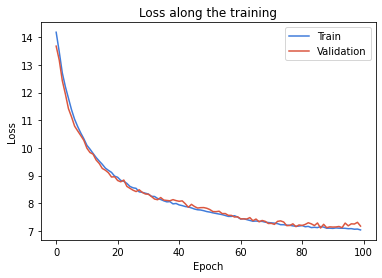

In [43]:
h_baseline_Unif = bs_trainer_Unif.train(100, train_loader, val_loader)
plot_history(h_baseline_Unif)

In [44]:
output_bs_Unif_train = target_eval(baseline_Unif, bs_trainer_Unif, train_loader)
output_bs_Unif_val = target_eval(baseline_Unif, bs_trainer_Unif, val_loader)

bs_bal_acc_Unif_train = balanced_accuracy_score(output_bs_Unif_train['y_true_label'], output_bs_Unif_train['y_pred'])
bs_auc_Unif_train = roc_auc_score(output_bs_Unif_train['y_true'], output_bs_Unif_train['y_pred_auc'])

bs_bal_acc_Unif_val = balanced_accuracy_score(output_bs_Unif_val['y_true_label'], output_bs_Unif_val['y_pred'])
bs_auc_Unif_val = roc_auc_score(output_bs_Unif_val['y_true'], output_bs_Unif_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bs_bal_acc_Unif_train,4), '\nauc:', round(bs_auc_Unif_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bs_bal_acc_Unif_val,4), '\nauc:', round(bs_auc_Unif_val,4))

Treino 
acurácia balanceada: 0.5808 
auc: 0.4378


Validação 
acurácia balanceada: 0.5747 
auc: 0.4444


### $lr = 10^{-4}$

In [45]:
baseline2_Unif = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="Unif")
bs_opt2_Unif = SGDOptimizer(baseline2_Unif, lr=1e-4)
bs_trainer2_Unif = Trainer(baseline2_Unif, bs_opt2_Unif, CrossEntropy())

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

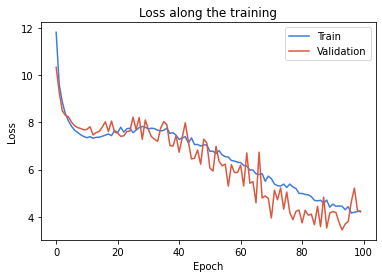

In [46]:
h_baseline2_Unif = bs_trainer2_Unif.train(100, train_loader, val_loader)
plot_history(h_baseline2_Unif)

In [47]:
output_bs2_Unif_train = target_eval(baseline2_Unif, bs_trainer2_Unif, train_loader)
output_bs2_Unif_val = target_eval(baseline2_Unif, bs_trainer2_Unif, val_loader)

bs_bal_acc2_Unif_train = balanced_accuracy_score(output_bs2_Unif_train['y_true_label'], output_bs2_Unif_train['y_pred'])
bs_auc2_Unif_train = roc_auc_score(output_bs2_Unif_train['y_true'], output_bs2_Unif_train['y_pred_auc'])

bs_bal_acc2_Unif_val = balanced_accuracy_score(output_bs2_Unif_val['y_true_label'], output_bs2_Unif_val['y_pred'])
bs_auc2_Unif_val = roc_auc_score(output_bs2_Unif_val['y_true'], output_bs2_Unif_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bs_bal_acc2_Unif_train,4), '\nauc:', round(bs_auc2_Unif_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bs_bal_acc2_Unif_val,4), '\nauc:', round(bs_auc2_Unif_val,4))

Treino 
acurácia balanceada: 0.4921 
auc: 0.5764


Validação 
acurácia balanceada: 0.4723 
auc: 0.5819


### $lr = 10^{-3}$

In [48]:
baseline3_Unif = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="Unif")
bs_opt3_Unif = SGDOptimizer(baseline3_Unif, lr=1e-3)
bs_trainer3_Unif = Trainer(baseline3_Unif, bs_opt3_Unif, CrossEntropy())

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

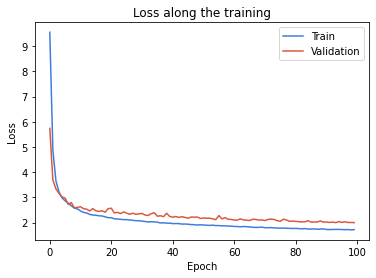

In [49]:
h_baseline3_Unif = bs_trainer3_Unif.train(100, train_loader, val_loader)
plot_history(h_baseline3_Unif)

In [51]:
output_bs3_Unif_train = target_eval(baseline3_Unif, bs_trainer3_Unif, train_loader)
output_bs3_Unif_val = target_eval(baseline3_Unif, bs_trainer3_Unif, val_loader)

bs_bal_acc3_Unif_train = balanced_accuracy_score(output_bs3_Unif_train['y_true_label'], output_bs3_Unif_train['y_pred'])
bs_auc3_Unif_train = roc_auc_score(output_bs3_Unif_train['y_true'], output_bs3_Unif_train['y_pred_auc'])

bs_bal_acc3_Unif_val = balanced_accuracy_score(output_bs3_Unif_val['y_true_label'], output_bs3_Unif_val['y_pred'])
bs_auc3_Unif_val = roc_auc_score(output_bs3_Unif_val['y_true'], output_bs3_Unif_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bs_bal_acc3_Unif_train,4), '\nauc:', round(bs_auc3_Unif_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bs_bal_acc3_Unif_val,4), '\nauc:', round(bs_auc3_Unif_val,4))

Treino 
acurácia balanceada: 0.2905 
auc: 0.5871


Validação 
acurácia balanceada: 0.2696 
auc: 0.5876


### Best baseline model

A técnica de inicialização dos pesos e *bias* de He el al., com $lr = 10^{-3}$, apresentou o melhor desempenho (com base na acurácia balanceada e AUC). Para a escolha do número de épocas, utilizou-se a função feita pelo grupo `best_epoch`, que retorna este valor assumindo um $\varepsilon$ de tolerância de ganho na *loss* em relação às épocas $i$ e $i+1$. Sendo assim, adotou-se uma tolerância de $\varepsilon = 0,1\%$. 

In [66]:
best_epoch(h_baseline3_he, 0.001)

51

In [67]:
best_baseline_he = Model([2352, 1100, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
bestbs_opt_he = SGDOptimizer(best_baseline_he, lr=1e-3)
bestbs_trainer_he = Trainer(best_baseline_he, bestbs_opt_he, CrossEntropy())

h_bestbaseline_he = bestbs_trainer_he.train(best_epoch(h_baseline3_he, 0.001), train_loader, val_loader)

C:\Users\mazza\AppData\Local\Temp/ipykernel_4812/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/51 [00:00<?, ?it/s]

In [70]:
output_bestbs_he_train = target_eval(best_baseline_he, bestbs_trainer_he, train_loader)
output_bestbs_he_val = target_eval(best_baseline_he, bestbs_trainer_he, val_loader)

bestbs_bal_acc_he_train = balanced_accuracy_score(output_bestbs_he_train['y_true_label'], output_bestbs_he_train['y_pred'])
bestbs_auc_he_train = roc_auc_score(output_bestbs_he_train['y_true'], output_bestbs_he_train['y_pred_auc'])

bestbs_bal_acc_he_val = balanced_accuracy_score(output_bestbs_he_val['y_true_label'], output_bestbs_he_val['y_pred'])
bestbs_auc_he_val = roc_auc_score(output_bestbs_he_val['y_true'], output_bestbs_he_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bestbs_bal_acc_he_train,4), '\nauc:', round(bestbs_auc_he_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bestbs_bal_acc_he_val,4), '\nauc:', round(bestbs_auc_he_val,4))

Treino 
acurácia balanceada: 0.8194 
auc: 0.5901


Validação 
acurácia balanceada: 0.7832 
auc: 0.5899


> What are the conclusions? How do the techniques influence the performance of the models? (1-2 paragraphs) 


  **Resposta:** Para o melhor baseline, utilizou-se o método de He et al. para a inicialização dos pesos e do *bias*, com o número ideal de épocas obtido em `best_epoch(h_baseline3_he, 0.001)`. Sendo assim, mesmo observando que para números maiores de épocas há uma menor *loss* (ganhos não muito significativos), optou-se por esse baseline segundo o princípio da Navalha de Occam, o qual, em suma, assume que a melhor solução é aquela com menor complexidade, mas com bons resultados, aceitando uma tolerância de $0,1\%$ de ganho na redução da *loss* em relação a épocas consecutivas. A acurácia e a AUC obtidas foram de, respectivamente e aproximadamente, $82\%$ e $59\%$ para o *dataset* de treino e $78\%$ e $59\%$ para o *dataset* de validação.
  
 No que tange na influência das inicializações na performance dos modelos, notou-se que a inicialização escolhida é a mais estável (para todos *lr* testados), enquanto o método de inicialização com com pesos aleatórios é o menos adequado por conta de sua instabilidade e também da baixa performance obtida nas métricas consideradas (acurácia balanceada e AUC).

3. (1 point) Choose the weight & bias initialization technique that resulted in the best performance, and try the other activation function you implemented.

**Solução**

C:\Users\bruno\AppData\Local\Temp\ipykernel_18932\2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/51 [00:00<?, ?it/s]

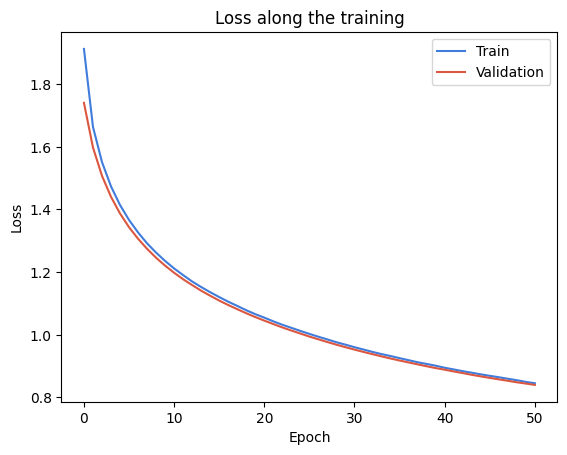

In [93]:
best_baseline = Model([2352, 1100, 100, 8], [ReLU(), Activation(), Softmax()], initialization_method="he")
bestbs_opt = SGDOptimizer(best_baseline, lr=1e-3)
bestbs_trainer = Trainer(best_baseline, bestbs_opt, CrossEntropy())

h_bestbaseline = bestbs_trainer.train(51, train_loader, val_loader)
plot_history(h_bestbaseline)

In [95]:
output_bestbs_train = target_eval(best_baseline, bestbs_trainer, train_loader)
output_bestbs_val = target_eval(best_baseline, bestbs_trainer, val_loader)

bestbs_bal_acc_train = balanced_accuracy_score(output_bestbs_train['y_true_label'], output_bestbs_train['y_pred'])
bestbs_auc_train = roc_auc_score(output_bestbs_train['y_true'], output_bestbs_train['y_pred_auc'])

bestbs_bal_acc_val = balanced_accuracy_score(output_bestbs_val['y_true_label'], output_bestbs_val['y_pred'])
bestbs_auc_val = roc_auc_score(output_bestbs_val['y_true'], output_bestbs_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(bestbs_bal_acc_train,4), '\nauc:', round(bestbs_auc_train,4))
print("\n")
print('Validação \nacurácia balanceada:', round(bestbs_bal_acc_val,4), '\nauc:', round(bestbs_auc_val,4))

Treino 
acurácia balanceada: 0.6504 
auc: 0.5367


Validação 
acurácia balanceada: 0.6479 
auc: 0.5437


> What are the conclusions? Does it make any difference in the results? (1-2 paragraphs) 


**Resposta:** Os resultados foram expressivamente afetados ao trocar a função de ativação *ReLU* do melhor baseline para uma *Sigmoid*, sobretudo ao analisar a métrica de acurácia balanceada (perdendo, aproximadamente, 20 pontos percentuais no conjunto de treino).

4. (3 points) Explore different network architectures, varying the number of layers and the number of neurons in each layer. It is an empirical experiment.

**Solução**

Foram consideradas cinco arquiteturas, variando o número de camadas e o número de neurônios em cada uma delas. Todos os testes foram realizados com hiperparâmetros definidos pelo melhor baseline: inicialização com método de He et al.,  otimizador SDG com *learning rate* de $0.001$. Ainda, fixou-se $51$ épocas por fins de recurso computacional (abaixo, poderá ser visto que um número de épocas menor poderia ser considerado na maioria dos casos).

O número de camadas foi obtido como consequência das escolhas do número de neurônios. Fixadas as camadas de entrada $l_{0}$ com $2352$ neurônios e $l_{n}$ com $8$, as regras para escolha de números de neurônios da $i$é-sima camada foram, 

$$m1: l_i = \dfrac{l_{i-1} + l_n}{2}, i:1,\dots,n-1; $$

$$m2: l_i = \dfrac{l_{i-1}}{k}, k:3,7,2  \mbox{ (fatores primos de } 2352), i:1,\dots,n-1; $$

$$m3: l_i = \dfrac{2\cdot l_{i-1}}{3}, i:1,\dots,n-1; $$

$$m4: l_i = \dfrac{3\cdot l_{i-1}}{4}, i:1,\dots,n-1 $$

e, para o modelo `m5`, foram escolhidas $8$ camadas escondidas cheias.

C:\Users\bruno\AppData\Local\Temp\ipykernel_18932\2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/51 [00:00<?, ?it/s]

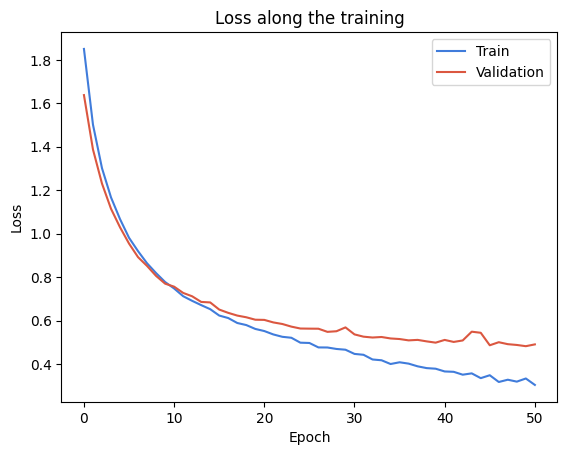

In [65]:
m1 = Model([2352, 1180, 594, 301, 154, 81, 44, 26, 15, 8], [ReLU(),ReLU(),ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Softmax()], initialization_method="he")
m1_opt = SGDOptimizer(m1, lr=1e-3)
m1_trainer = Trainer(m1, m1_opt, CrossEntropy())

h_m1 = m1_trainer.train(51, train_loader, val_loader)
plot_history(h_m1)

In [66]:
output_m1_train = target_eval(m1, m1_opt, train_loader)
output_m1_val = target_eval(m1, m1_opt, val_loader)

m1_train_bal_acc = balanced_accuracy_score(output_m1_train['y_true_label'], output_m1_train['y_pred'])
m1_train_auc = roc_auc_score(output_m1_train['y_true'], output_m1_train['y_pred_auc'])

m1_val_bal_acc = balanced_accuracy_score(output_m1_val['y_true_label'], output_m1_val['y_pred'])
m1_val_auc = roc_auc_score(output_m1_val['y_true'], output_m1_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(m1_train_bal_acc,4), '\nauc:', round(m1_train_auc,4))
print("\n")
print('Validação \nacurácia balanceada:', round(m1_val_bal_acc,4), '\nauc:', round(m1_val_auc,4))

Treino 
acurácia balanceada: 0.8788 
auc: 0.7029


Validação 
acurácia balanceada: 0.7907 
auc: 0.6624


C:\Users\bruno\AppData\Local\Temp\ipykernel_18932\2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/51 [00:00<?, ?it/s]

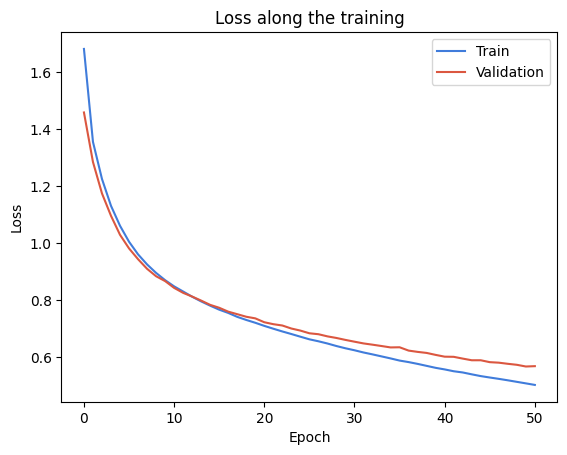

In [20]:
m2 = Model([2352, 784, 112, 18, 8], [ReLU(), ReLU(), ReLU(), Softmax()], initialization_method="he")
m2_opt = SGDOptimizer(m2, lr=1e-3)
m2_trainer = Trainer(m2, m2_opt, CrossEntropy())

h_m2 = m2_trainer.train(51, train_loader, val_loader)
plot_history(h_m2)

In [21]:
output_m2_train = target_eval(m2, m2_opt, train_loader)
output_m2_val = target_eval(m2, m2_opt, val_loader)

m2_train_bal_acc = balanced_accuracy_score(output_m2_train['y_true_label'], output_m2_train['y_pred'])
m2_train_auc = roc_auc_score(output_m2_train['y_true'], output_m2_train['y_pred_auc'])

m2_val_bal_acc = balanced_accuracy_score(output_m2_val['y_true_label'], output_m2_val['y_pred'])
m2_val_auc = roc_auc_score(output_m2_val['y_true'], output_m2_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(m2_train_bal_acc,4), '\nauc:', round(m2_train_auc,4))
print("\n")
print('Validação \nacurácia balanceada:', round(m2_val_bal_acc,4), '\nauc:', round(m2_val_auc,4))

Treino 
acurácia balanceada: 0.7806 
auc: 0.51


Validação 
acurácia balanceada: 0.7556 
auc: 0.5182


C:\Users\bruno\AppData\Local\Temp\ipykernel_18932\2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/51 [00:00<?, ?it/s]

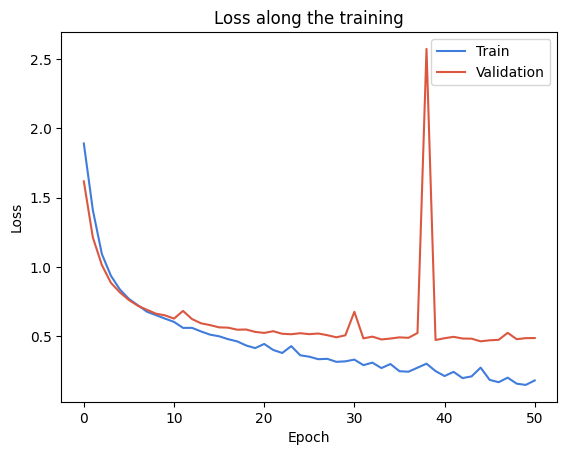

In [28]:
m3 = Model([2352, 1568, 1045, 696, 464, 309, 206, 137, 91, 61, 40, 27, 8],
           [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Softmax()], initialization_method="he")
m3_opt = SGDOptimizer(m3, lr=1e-3)
m3_trainer = Trainer(m3, m3_opt, CrossEntropy())

h_m3 = m3_trainer.train(51, train_loader, val_loader)
plot_history(h_m3)

In [23]:
output_m3_train = target_eval(m3, m3_opt, train_loader)
output_m3_val = target_eval(m3, m3_opt, val_loader)

m3_train_bal_acc = balanced_accuracy_score(output_m3_train['y_true_label'], output_m3_train['y_pred'])
m3_train_auc = roc_auc_score(output_m3_train['y_true'], output_m3_train['y_pred_auc'])

m3_val_bal_acc = balanced_accuracy_score(output_m3_val['y_true_label'], output_m3_val['y_pred'])
m3_val_auc = roc_auc_score(output_m3_val['y_true'], output_m3_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(m3_train_bal_acc,4), '\nauc:', round(m3_train_auc,4))
print("\n")
print('Validação \nacurácia balanceada:', round(m3_val_bal_acc,3), '\nauc:', round(m3_val_auc,4))

Treino 
acurácia balanceada: 0.964 
auc: 0.59


Validação 
acurácia balanceada: 0.809 
auc: 0.5796


C:\Users\bruno\AppData\Local\Temp\ipykernel_18932\2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/51 [00:00<?, ?it/s]

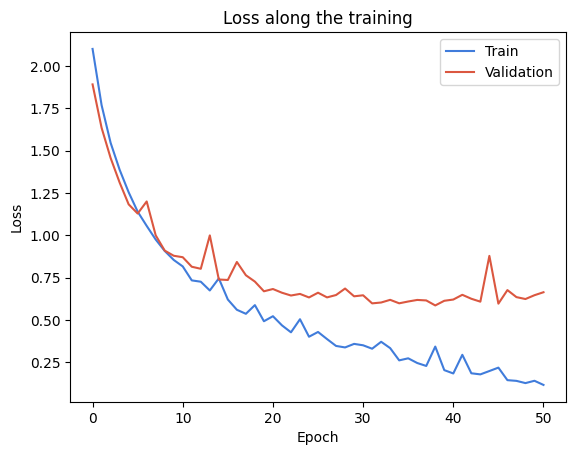

In [24]:
m4 = Model([2352, 1764, 1323, 992, 744, 558, 418, 313, 235, 176, 132, 99, 74, 55, 42, 31, 23, 17, 8],
           [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(),
            ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Softmax()], 
           initialization_method="he")
m4_opt = SGDOptimizer(m4, lr=1e-3)
m4_trainer = Trainer(m4, m4_opt, CrossEntropy())

h_m4 = m4_trainer.train(51, train_loader, val_loader)
plot_history(h_m4)

In [25]:
output_m4_train = target_eval(m4, m4_opt, train_loader)
output_m4_val = target_eval(m4, m4_opt, val_loader)

m4_train_bal_acc = balanced_accuracy_score(output_m4_train['y_true_label'], output_m4_train['y_pred'])
m4_train_auc = roc_auc_score(output_m4_train['y_true'], output_m4_train['y_pred_auc'])

m4_val_bal_acc = balanced_accuracy_score(output_m4_val['y_true_label'], output_m4_val['y_pred'])
m4_val_auc = roc_auc_score(output_m4_val['y_true'], output_m4_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(m4_train_bal_acc,4), '\nauc:', round(m4_train_auc,4))
print("\n")
print('Validação \nacurácia balanceada:', round(m4_val_bal_acc,3), '\nauc:', round(m4_val_auc,4))

Treino 
acurácia balanceada: 0.9582 
auc: 0.7593


Validação 
acurácia balanceada: 0.779 
auc: 0.7118


C:\Users\bruno\AppData\Local\Temp\ipykernel_18932\2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/51 [00:00<?, ?it/s]

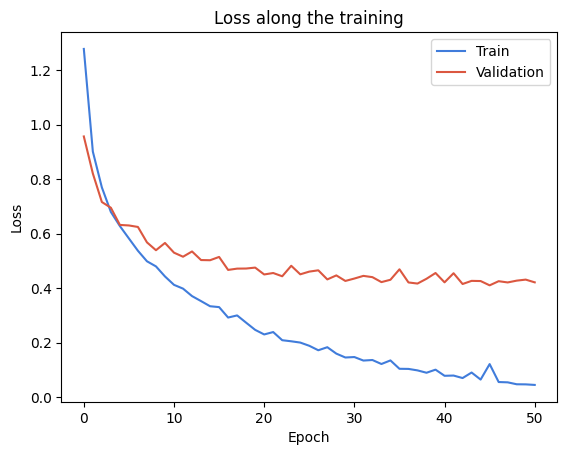

In [26]:
m5 = Model([2352, 2352, 2352, 2352, 2352, 2352, 2352, 2352, 2352, 8],
           [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Softmax()], initialization_method="he")
m5_opt = SGDOptimizer(m5, lr=1e-3)
m5_trainer = Trainer(m5, m5_opt, CrossEntropy())

h_m5 = m5_trainer.train(51, train_loader, val_loader)
plot_history(h_m5)

In [27]:
output_m5_train = target_eval(m5, m5_opt, train_loader)
output_m5_val = target_eval(m5, m5_opt, val_loader)

m5_train_bal_acc = balanced_accuracy_score(output_m5_train['y_true_label'], output_m5_train['y_pred'])
m5_train_auc = roc_auc_score(output_m5_train['y_true'], output_m5_train['y_pred_auc'])

m5_val_bal_acc = balanced_accuracy_score(output_m5_val['y_true_label'], output_m5_val['y_pred'])
m5_val_auc = roc_auc_score(output_m5_val['y_true'], output_m5_val['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(m5_train_bal_acc,4), '\nauc:', round(m5_train_auc,4))
print("\n")
print('Validação \nacurácia balanceada:', round(m5_val_bal_acc,3), '\nauc:', round(m5_val_auc,4))

Treino 
acurácia balanceada: 0.9975 
auc: 0.5831


Validação 
acurácia balanceada: 0.834 
auc: 0.5741


> What are the conclusions? How does the number of layers impact the performance of the models? (2-4 paragraphs) 


**Resposta:** Primeiramente, foi notório que na grande maioria dos modelos testados, o número de épocas ideal é menor do que o proposto no limite dos gráficos, em que ora não havia um ganho expressivo na redução da *loss* na validação, ora o modelo sofria de overfitting. 

Dos modelos, os que obtiveram melhor desempenho em relação a AUC foram o modelo `m4` e o modelo `m1`, sendo o modelo `m4` o candidato ao modelo final. Apesar do melhor dos modelos apresentar o maior número de camadas, aumentar esse número ou o número de neurônios nas camadas (`m5`) não indicou melhoria expressiva do modelo. O que de fato aconteceu foi que modelos com mais neurônios por camadas exigiram mais recursos computacionais e apresentaram pior desempenho.

De modo geral, o que se pode concluir nesse caso é que um número decrescente de neurônios por camada executa o processo de aprendizagem efetivamente e sem muita exigência computacional.

5. (2 points) Pick the best network architecture and train your model using the optimizer you chose to implement.

**Solução**

Do melhor modelo, `m4`, notou-se que, após 30 épocas, o modelo não apresentou redução considerável na curva de *loss* na validação. Logo, decidiu-se utilizar este número para testar com o otimizador de momentos, implementado pelo grupo (referência:  https://ruder.io/optimizing-gradient-descent/index.html#momentum).

C:\Users\mazza\AppData\Local\Temp/ipykernel_18320/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/51 [00:00<?, ?it/s]

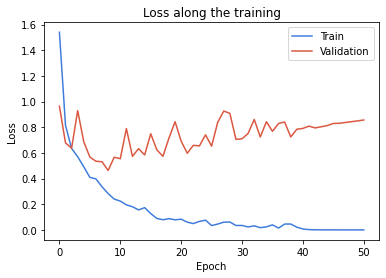

In [48]:
m4_momentum = Model([2352, 1764, 1323, 992, 744, 558, 418, 313, 235, 176, 132, 99, 74, 55, 42, 31, 23, 17, 8],
           [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), 
            ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Softmax()], 
           initialization_method="he")
m4_opt_momentum = MomentumOptim(m4_momentum, lr=1e-3)
m4_trainer_momentum = Trainer(m4_momentum, m4_opt_momentum, CrossEntropy())

h_m4_momentum = m4_trainer_momentum.train(51, train_loader, val_loader)
plot_history(h_m4_momentum)

In [50]:
output_mbest1_train_momentum = target_eval(m4_momentum, m4_trainer_momentum, train_loader)
output_mbest_val_momentum = target_eval(m4_momentum, m4_opt_momentum, val_loader)

m4_train_bal_acc_momentum = balanced_accuracy_score(output_mbest1_train_momentum['y_true_label'], output_mbest1_train_momentum['y_pred'])
m4_train_auc_momentum = roc_auc_score(output_mbest1_train_momentum['y_true'], output_mbest1_train_momentum['y_pred_auc'])

m4_val_bal_acc_momentum = balanced_accuracy_score(output_mbest_val_momentum['y_true_label'], output_mbest_val_momentum['y_pred'])
m4_val_auc_momentum = roc_auc_score(output_mbest_val_momentum['y_true'], output_mbest_val_momentum['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(m4_train_bal_acc_momentum,4), '\nauc:', round(m4_train_auc_momentum,4))
print("\n")
print('Validação \nacurácia balanceada:', round(m4_val_bal_acc_momentum,3), '\nauc:', round(m4_val_auc_momentum,4))

Treino 
acurácia balanceada: 1.0 
auc: 0.6799


Validação 
acurácia balanceada: 0.854 
auc: 0.6783


Do gráfico acima, notou-se que após 20 épocas, o modelo passou a sofrer de *overfitting*, dado o crescimento, a partir de então, da curva de *loss* na validação. Sendo assim, optou-se por modificar este hiperparâmetro para 30.

C:\Users\mazza\AppData\Local\Temp/ipykernel_18320/2121061162.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

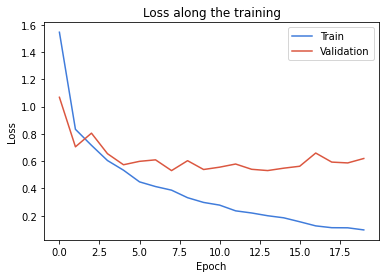

In [42]:
m4_momentum = Model([2352, 1764, 1323, 992, 744, 558, 418, 313, 235, 176, 132, 99, 74, 55, 42, 31, 23, 17, 8],
           [ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), 
            ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), Softmax()], 
           initialization_method="he")
m4_opt_momentum = MomentumOptim(m4_momentum, lr=1e-3)
m4_trainer_momentum = Trainer(m4_momentum, m4_opt_momentum, CrossEntropy())

h_m4_momentum = m4_trainer_momentum.train(20, train_loader, val_loader)
plot_history(h_m4_momentum)

In [43]:
output_mbest1_train_momentum = target_eval(m4_momentum, m4_trainer_momentum, train_loader)
output_mbest_val_momentum = target_eval(m4_momentum, m4_opt_momentum, val_loader)

m4_train_bal_acc_momentum = balanced_accuracy_score(output_mbest1_train_momentum['y_true_label'], output_mbest1_train_momentum['y_pred'])
m4_train_auc_momentum = roc_auc_score(output_mbest1_train_momentum['y_true'], output_mbest1_train_momentum['y_pred_auc'])

m4_val_bal_acc_momentum = balanced_accuracy_score(output_mbest_val_momentum['y_true_label'], output_mbest_val_momentum['y_pred'])
m4_val_auc_momentum = roc_auc_score(output_mbest_val_momentum['y_true'], output_mbest_val_momentum['y_pred_auc'])

print('Treino \nacurácia balanceada:', round(m4_train_bal_acc_momentum,4), '\nauc:', round(m4_train_auc_momentum,4))
print("\n")
print('Validação \nacurácia balanceada:', round(m4_val_bal_acc_momentum,3), '\nauc:', round(m4_val_auc_momentum,4))

Treino 
acurácia balanceada: 0.9743 
auc: 0.5917


Validação 
acurácia balanceada: 0.828 
auc: 0.5755


> What are the conclusions? Does the change of optimizer anyhow impact the loss curve over the epochs? (1-2 paragraphs) 


**Resposta:** De maneira geral, o otimizador de momentos apresentou uma boa perfomance com base no melhor modelo obtido pelo grupo. No entanto, com respeito à curva de *loss* $\times$ épocas, este aparentou ser mais instável, com oscilações significantes e mais sensível a *overfitting* do modelo, o que requeriu uma maior atenção dos integrantes para a escolha desse hiperparâmetro. Ao reduzir para o número de épocas em que não houve um cenário de *overfitting*, o modelo apresentou uma menor performance do que considerando o otimizador SGD.

**Resposta:**

6. (1 point) Pick your **best model**, make predictions to the test set and submit them to the Kaggle competition [3rd ML Assignment](https://www.kaggle.com/t/cbf42d49ae514153bd4d04e0a69d684f). Print your score considering the public leaderboard.

In [44]:
def target_test(model, trainer, loader):

        output_dict = {'y_pred': [],
                       'y_pred_auc': []}

        for epoch, batch in enumerate(loader):
                X = batch
                X = X.numpy()
                
                Y_pred = trainer.model.forward(X)
                Y_pred_auc = Y_pred[:, 1]

                Y_pred = np.argmax(Y_pred, axis=1)
                output_dict['y_pred'].extend(Y_pred)
                output_dict['y_pred_auc'].extend(Y_pred_auc.reshape(-1, 1))
                
        return output_dict

In [ ]:
result = target_test(m4, m4_trainer, test_loader)['y_pred']

In [52]:
import pandas as pd

targets = pd.DataFrame(result, columns = ['cell_type'])
targets['index'] = targets.index
targets.head()

,cell_type,index
0,5,0
1,0,1
2,1,2
3,3,3
4,1,4


In [53]:
targets.to_csv('sample_submission.csv',index=False)

> What are the conclusions? (1-2 paragraphs)

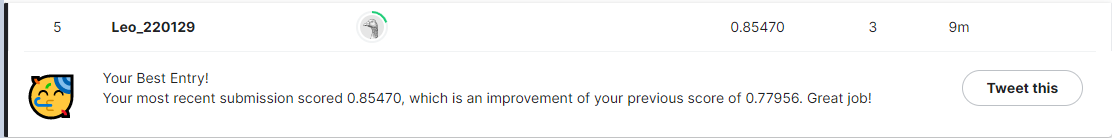

**Resposta:** Embora o melhor desempenho obtido pelo grupo fora $85,47\%$ de AUC, com o modelo `m4_momentum` (epochs = 51, momentum opt., *lr = 1e-3*), notou-se que este estava claramente *overfittado* e, como teve melhor desempenho, há indícios que o *dataset* de teste apresenta uma classe mais frequente, a qual foi bem aprendida pelo modelo (introduzindo um possível viés e falsa sensação de boa performance). Sendo assim, o grupo escolheu, de forma definitiva para este trabalho, o modelo `m4` (epochs = 51, SGD opt., *lr = 1e-3*), que apresentou, aproximadamente, $77,96\%$ de AUC.